In [ ]:
!pip install anytree

In [ ]:
from anytree import Node, RenderTree
from anytree.search import findall
import numpy as np

In [ ]:
getNameOfChildNode = lambda string, rule: string.replace(rule[1], rule[0])
getRuleProbability = lambda rule: rule[2]

def expandNode(node, allIntermediateRules):
  string = node.name
  nodeProb = node.probability
  for rule in allIntermediateRules:
    nameOfChildNode = getNameOfChildNode(string, rule)
    if nameOfChildNode != string:
      childProb = nodeProb * getRuleProbability(rule)
      childNode = Node(nameOfChildNode, parent=node, probability=childProb)
      expandNode(childNode, allIntermediateRules)

def rreplace(s, old, new, occurrence):
  li = s.rsplit(old, occurrence)
  return new.join(li)

In [ ]:
def computeLikelihoodOfString(string, theta):
  terminalRule = ("Y", "b", 0.2)
  allIntermediateRules = [("X", "aX", 0.8), ("X", "bY", 0.2), ("Y", "bY", 0.2), ("Y", "bX", 0.2)]
  startingRules = [("S", "X", theta), ("S", "Y", 1-theta)]
  startingSymbol = "S"

  root = Node(string, parent=None, probability=1)
  # apply terminal rule
  firstChild = Node(rreplace(string, terminalRule[1], terminalRule[0], 1), parent=root, probability=root.probability*terminalRule[2])
  # expand tree
  expandNode(firstChild, allIntermediateRules)
  # apply starting rules
  for rule in startingRules:
    allLeafNodesPossibleFromThisRule = findall(root, filter_=lambda node: node.name == rule[1])
    [Node(rule[0], parent=leafNode, probability=leafNode.probability*rule[2]) for leafNode in allLeafNodesPossibleFromThisRule]

  # compute string probability
  allStartingSymbols = findall(root, filter_=lambda node: node.name == startingSymbol)
  stringProbability = sum([node.probability for node in allStartingSymbols])

  # for pre, fill, node in RenderTree(root):
  #    print("%s%s   %.4f" % (pre, node.name, node.probability))

  return stringProbability

computeLikelihoodOfString("aaabbbb", 0.5)

0.0008192000000000004

In [ ]:
def forwardModel(theta):
  startingSymbol = "S"
  nonTerminals = {"S": [("X", theta), ("Y", 1-theta)], "X": [("aX", 0.8), ("bY", 0.2)], "Y": [("bY", 0.2), ("bX", 0.2), ("b", 0.2)]}

  string = startingSymbol
  while(True):
    print(string)
    for nonTerminal in nonTerminals:
      if nonTerminal in string:
        rightSides = [rule[0] for rule in nonTerminals[nonTerminal]]
        probabilities = [rule[1] for rule in nonTerminals[nonTerminal]]
        sampledRightSide = np.random.choice(rightSides, 1, probabilities)[0]
        newString = string.replace(nonTerminal, sampledRightSide)
        continue
    
    if newString == string:
      print("--------")
      return newString

    string = newString


generateObservations = lambda theta, numObservations: [forwardModel(theta) for _ in range(numObservations)]
print(generateObservations(0.1, 10))

S
X
aX
abY
abb
--------
S
Y
b
--------
S
Y
b
--------
S
Y
bY
bbY
bbb
--------
S
Y
b
--------
S
Y
bY
bbY
bbbY
bbbbX
bbbbbY
bbbbbbX
bbbbbbaX
bbbbbbaaX
bbbbbbaabY
bbbbbbaabbX
bbbbbbaabbaX
bbbbbbaabbaaX
bbbbbbaabbaabY
bbbbbbaabbaabbY
bbbbbbaabbaabbb
--------
S
Y
bY
bbX
bbaX
bbabY
bbabb
--------
S
X
bY
bbX
bbbY
bbbb
--------
S
Y
bY
bbX
bbaX
bbabY
bbabbX
bbabbbY
bbabbbbX
bbabbbbaX
bbabbbbaaX
bbabbbbaaaX
bbabbbbaaaaX
bbabbbbaaaaaX
bbabbbbaaaaabY
bbabbbbaaaaabbY
bbabbbbaaaaabbbX
bbabbbbaaaaabbbaX
bbabbbbaaaaabbbabY
bbabbbbaaaaabbbabb
--------
S
Y
bX
bbY
bbb
--------
['abb', 'b', 'b', 'bbb', 'b', 'bbbbbbaabbaabbb', 'bbabb', 'bbbb', 'bbabbbbaaaaabbbabb', 'bbb']


In [ ]:
class MetropolisHastings:
  def __init__(self, thetaInitValue, proposalFunction, likelihood, prior, proposalKernel):
    self.thetaInitValue = thetaInitValue
    self.proposalFunction = proposalFunction
    self.likelihood = likelihood
    self.prior = prior
    self.proposalKernel = proposalKernel

  def __call__(self, numIterations, observations):
      samples = []
      theta = self.thetaInitValue
      
      for iteration in range(numIterations):
        thetaProposed = self.proposalFunction(theta)
        ratio = (self.likelihood(observations, thetaProposed)*self.prior(thetaProposed)*self.proposalKernel(theta, thetaProposed))/(self.likelihood(observations, theta)*self.prior(theta)*self.proposalKernel(thetaProposed, theta))
        if np.random.rand() < ratio:
            theta = thetaProposed
        samples.append(theta)

      return samples

In [ ]:
thetaInitValue = 0.5
proposalFunction = lambda theta: np.random.rand()
def likelihood(observations, theta):
  product = 1
  individualLikelihoods = [computeLikelihoodOfString(observation, theta) for observation in observations]
  for likelihood in individualLikelihoods:
    product *= likelihood
  return product
prior = lambda theta: 1
proposalKernel = lambda new, old: 1

mh = MetropolisHastings(thetaInitValue, proposalFunction, likelihood, prior, proposalKernel)
observations = ['abb', 'b', 'b', 'bbb', 'b', 'bbbbbbaabbaabbb', 'bbabb', 'bbbb', 'bbabbbbaaaaabbbabb', 'bbb']
samples = mh(50000, observations)

(array([ 5787., 11511., 11314.,  8823.,  6014.,  3580.,  1865.,   799.,
          263.,    44.]),
 array([7.20243140e-04, 9.36178519e-02, 1.86515461e-01, 2.79413070e-01,
        3.72310678e-01, 4.65208287e-01, 5.58105896e-01, 6.51003505e-01,
        7.43901113e-01, 8.36798722e-01, 9.29696331e-01]),
 <a list of 10 Patch objects>)

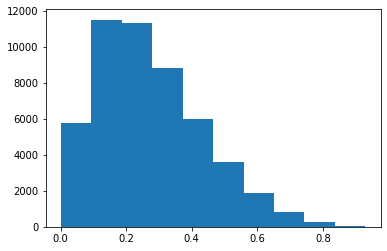

In [ ]:
import matplotlib.pyplot as plt
plt.hist(samples)